## Packages Used 
* Pandas
* Numpy
* SciKit Learn
* Matplot Lib
* Seaborn

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# TODO replace sns with matplot
from matplotlib import pyplot as plt
import seaborn as sns

## Loading data from CSV to Pandas DataFrame

In [2]:
data = pd.read_csv("DataSet_PCP_Change.csv")

## Statistical Information from raw data

Little over 4% people opts to change their PCP

In [3]:
print(data.outcome.value_counts(normalize=True) * 100)
data.groupby(by='outcome', as_index=False).agg({'testindex': pd.Series.nunique})

0    95.942492
1     4.057508
Name: outcome, dtype: float64


,outcome,testindex
0,0,3003
1,1,127


## Feature Enrichement

Remove rows with missing target. 
Separate target from predictors by moving outcome colume to DF `y` and removing from the main `data` DF

In [4]:
data.dropna(axis=0, subset=['outcome'], inplace=True)
y = data.outcome
data.drop(['outcome'], axis=1, inplace=True)

replace all NaN with 0

In [5]:
data = data.fillna(0)

Binning for feature `distance` is required as the boxplot clearly shows that mostly distance is in range 0 to 5. 
Raw values of feature `distance` will lead to inaccurate predictions

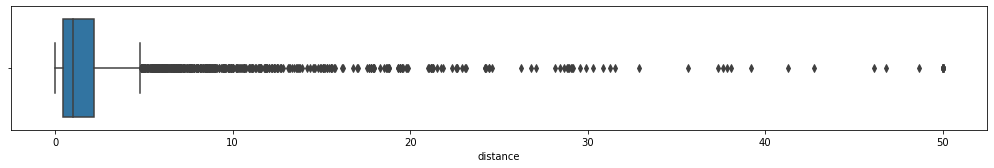

In [6]:
fig, ax = plt.subplots(figsize=(17.5, 2.27))
ax = sns.boxplot(x=data.distance)

In [7]:
# zone_labels = ["zone1", "zone2", "zone3", "zone4"]
zone_labels = ["1", "2", "3", "4"]
data['distance_bin'] = pd.cut(data['distance'], bins=[0, 2, 5, 10, 60], labels=zone_labels, include_lowest=True)
# categories = np.array(zone_labels)
# data['distance_bin'] = pd.Categorical(data['distance_bin'], categories=categories, ordered=True)

data.drop(['distance'], axis=1, inplace=True)

# convert dtype for `distance_bin` from category to float
data["distance_bin"] = data.distance_bin.astype(float)

Binning for `visit_count` is also required, as absolute number of visits per member is irrelevant. 
Rather stratified visit count information in 

* visit_count = 0 -> not a visitor
* visit_count > 0 and visit_count < 25 -> moderate visitor
* visit_count > 25 -> frequent visitor

In [8]:
visit_count_labels = [0, 1, 2]
data['visit_count_bin'] = pd.cut(data['visit_count'], bins=[0, 1, 25, 40], labels=visit_count_labels, include_lowest=True)

data.drop(['visit_count'], axis=1, inplace=True)

# convert dtype for `distance_bin` from category to float
data["visit_count_bin"] = data.visit_count_bin.astype(float)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3130 entries, 0 to 3129
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   testindex          3130 non-null   int64  
 1   claims_daysaway    3130 non-null   float64
 2   tier               3130 non-null   float64
 3   fqhc               3130 non-null   int64  
 4   pcp_lookback       3130 non-null   int64  
 5   family_assignment  3130 non-null   int64  
 6   kid                3130 non-null   int64  
 7   is_ped             3130 non-null   int64  
 8   same_gender        3130 non-null   int64  
 9   same_language      3130 non-null   int64  
 10  same_address       3130 non-null   int64  
 11  distance_bin       3130 non-null   float64
 12  visit_count_bin    3130 non-null   float64
dtypes: float64(4), int64(9)
memory usage: 342.3 KB


In [10]:
data.describe()

,testindex,claims_daysaway,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address,distance_bin,visit_count_bin
count,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,2519.981789,24.039617,1.809585,0.192332,0.442173,0.341853,0.376997,0.392332,0.511821,0.064856,0.065495,1.473482,0.180511
std,1439.130702,72.747243,0.995116,0.394196,0.496724,0.474406,0.484712,0.488348,0.499940,0.246311,0.247437,0.883118,0.392080
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1271.250000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2520.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,3769.750000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000
max,5000.000000,736.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000


## Histogram to visualize all the possible features and the spread of their values.

In [11]:
# data.hist(figsize=(18,14))

In [12]:
print(data.shape, y.shape)
# print(data.columns)

(3130, 13) (3130,)


## Split the data in Training and Testing dataset using `train_test_split` method from sklearn.

In [13]:
# Break-off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(data, y, train_size=0.7, test_size=0.3, random_state=1)

In [14]:
features = ['visit_count_bin', 'tier', 'fqhc', 'pcp_lookback', 'family_assignment', 'kid', 'is_ped', 'same_gender', 'same_language', 'same_address', 'distance_bin']
feature_names = np.array(features)

# Measuring Accuracy of the Predictions

## Mean Absolute Error


## Accuracy Score

In classification, accuracy score function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

Best performance is considered when Accuracy Score = 1 (or 100 in %)

## Precision - Recall

## Confusion Matrix 

The confusion matrix is a useful tool for analyzing how well our classifier can recongnize tuples of different classes.

 - TP and TN tells us when the classifier is getting things right
 - FP and FN tells us when the classifier is getthing things wrong i.e. *mislabeling*

## AUC - ROC curve
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. 

By analogy, the Higher the AUC, the better the model is at distinguishing between member that is more likely to leave their assigned primary care physician


# Feature Importance

SciKit Learn Model generates scores to measure importance of each feature based on their contribution towards training and prediction

Analysis shows that features `pcp_lookback`, `visit_count`, `tier`, `distance` have greater importance compared to other features.
It can be concluded that, it is more likely that a member will not want to change their PCP:

* if a member's visit count is high and that member is assigned his/her old PCP.
* if a member's visit count is high and the distance to PCP is less 
 

# Models and Predictions

## Classification using RandomForest

MAE: 5.537806176783812
Accuracy Score: 94.46219382321618


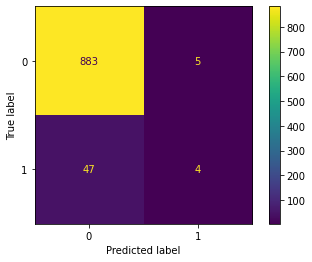

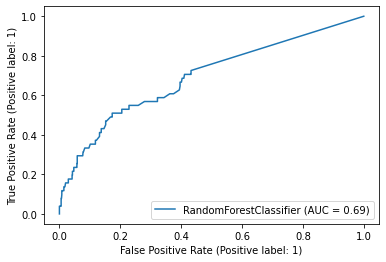

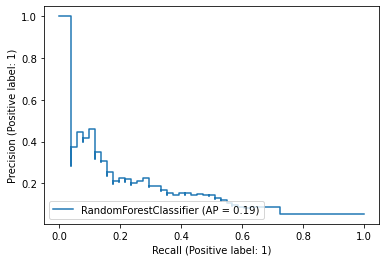

In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

print(f"MAE: {mean_absolute_error(y_valid, preds) * 100}")
print(f"Accuracy Score: {accuracy_score(y_valid, preds) * 100}")

importance = np.array(model.feature_importances_)

plot_confusion_matrix(model, X_valid[features], y_valid)  
plot_roc_curve(model, X_valid[features], y_valid)
plot_precision_recall_curve(model, X_valid[features], y_valid)

Text(0.5, 1.0, 'RandomForestClassifier Feature Importance')

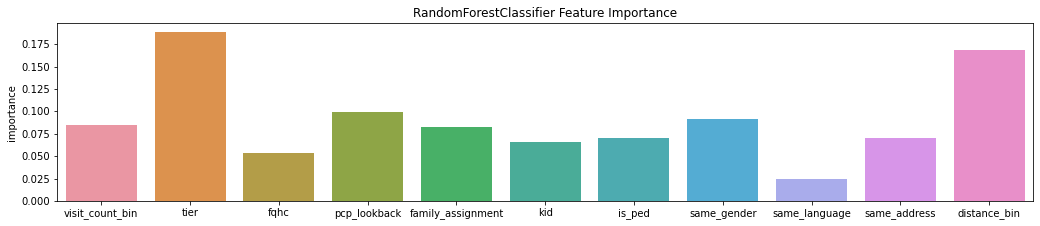

In [16]:
FI_data = {
    'feature_name': feature_names,
    'importance': importance
}
FI = pd.DataFrame(FI_data)

FI.set_index('feature_name')
FI.sort_values(by=['importance'], ascending=False)

fig, ax = plt.subplots(figsize=(17.5, 3.27))
ax = sns.barplot(x=FI.index, y='importance', data=FI)

ax.set_xticklabels(FI.feature_name)
ax.set_title("RandomForestClassifier Feature Importance")

## Classification using Decision Trees [criterion='gini']

MAE: 5.431309904153355
Accuracy Score: 94.56869009584665


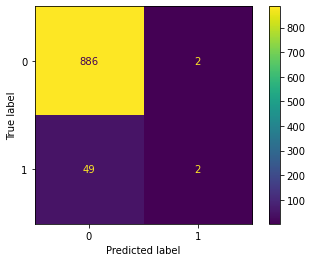

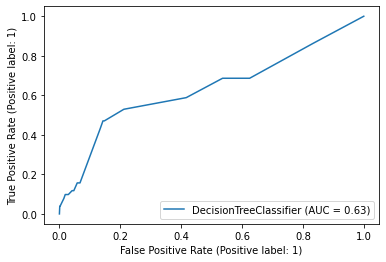

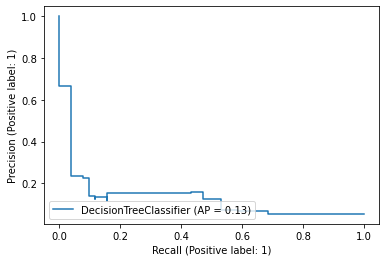

In [17]:
model = DecisionTreeClassifier(criterion='gini', random_state=1, max_depth=5)
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

print(f"MAE: {mean_absolute_error(y_valid, preds) * 100}")
print(f"Accuracy Score: {accuracy_score(y_valid, preds) * 100}")

importance = np.array(model.feature_importances_)

plot_confusion_matrix(model, X_valid[features], y_valid)  
plot_roc_curve(model, X_valid[features], y_valid)
plot_precision_recall_curve(model, X_valid[features], y_valid)

Text(0.5, 1.0, 'DecisionTreeClassifier {GINI} Feature Importance')

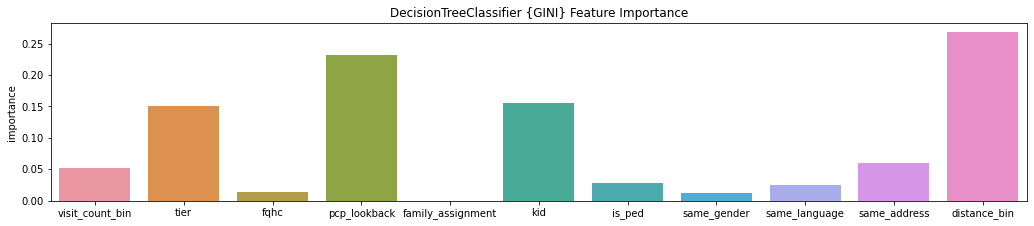

In [18]:
FI_data = {
    'feature_name': feature_names,
    'importance': importance
}
FI = pd.DataFrame(FI_data)

FI.set_index('feature_name')
FI.sort_values(by=['importance'], ascending=False)

fig, ax = plt.subplots(figsize=(17.5, 3.27))
ax = sns.barplot(x=FI.index, y='importance', data=FI)

ax.set_xticklabels(FI.feature_name)
ax.set_title("DecisionTreeClassifier {GINI} Feature Importance")

## Classification using Decision Trees [criterion='entropy']

MAE: 5.644302449414271
Accuracy Score: 94.35569755058573


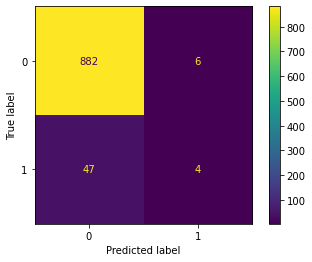

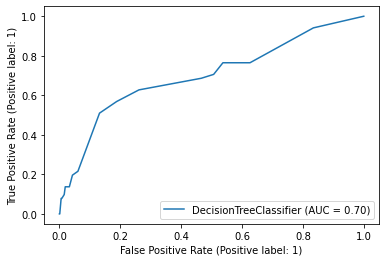

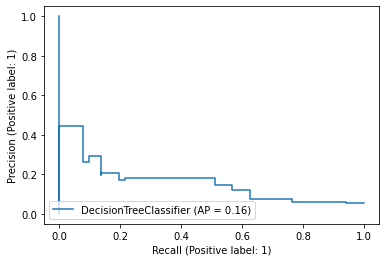

In [21]:
model = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=5)
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

print(f"MAE: {mean_absolute_error(y_valid, preds) * 100}")
print(f"Accuracy Score: {accuracy_score(y_valid, preds) * 100}")

importance = np.array(model.feature_importances_)

plot_confusion_matrix(model, X_valid[features], y_valid)  
plot_roc_curve(model, X_valid[features], y_valid)
plot_precision_recall_curve(model, X_valid[features], y_valid)

Text(0.5, 1.0, 'DecisionTreeClassifier {ENTROPY} Feature Importance')

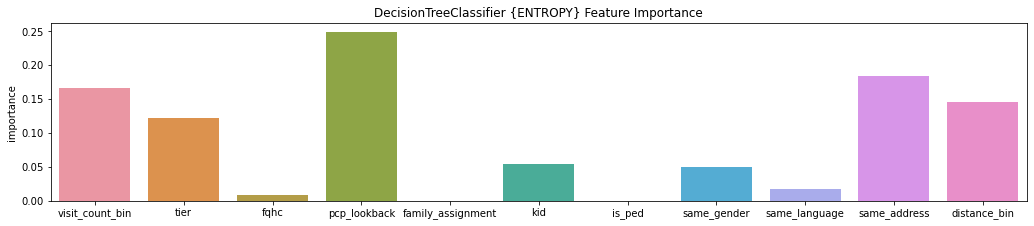

In [20]:
FI_data = {
    'feature_name': feature_names,
    'importance': importance
}
FI = pd.DataFrame(FI_data)

FI.set_index('feature_name')
FI.sort_values(by=['importance'], ascending=False)

fig, ax = plt.subplots(figsize=(17.5, 3.27))
ax = sns.barplot(x=FI.index, y='importance', data=FI)

ax.set_xticklabels(FI.feature_name)
ax.set_title("DecisionTreeClassifier {ENTROPY} Feature Importance")